In [2]:
# automatically apply changes in netgen
%reload_ext autoreload
%autoreload 2

In [277]:
import os, sys
import pandas as pd
import numpy as np
import random
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.analyzefx as afx
from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)
# splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
# bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

## Global Params

In [278]:
parentDir = 'cbgtDemoTEST11'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)

BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=600

presetNo = ng.set_post_learning_weights(dMSN=[1.0, 1.0], iMSN=[1.0,1.0])
presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetNo, presetLow, presetHi]

conds = ['no', 'low', 'high']
condABC = ['z', 'a', 'b']
cond12 = [0, 1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveNo, saveLow, saveHi = savedirs
saveTest=os.path.join(savedir, 'test')

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

# Efficacy sampling f(x) for individual networks

In [286]:
def get_sampling_params(scale=.05):
    
    CxSTR      =    0.2*.7 # overrides value in netgen.py, but is also partially overridden by dpmn_w
    CxTh       =    0.03*.1
    CxFSI      =    0.165
    D1STR_GPi  =    1.10*1.5 #1.07
    D2STR_GPeP =    1.65
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    STN_GPi    =    0.0324
    GPi_Th     =    0.067*0.8
    ThSTR      =    0.34*1.5
    ThCx       =    0.02
    
    CxSTR      =    0.2*.7
    CxTh       =    0.03
    CxFSI      =    0.165
    D1STR_GPi  =    1.10 #1.07
    D2STR_GPeP =    1.65
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    STN_GPi    =    0.0324
    GPi_Th     =    0.067
    ThSTR      =    0.34
    ThCx       =    0.02

    mu = dict(Cx={'STR':CxSTR, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STR':ThSTR, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi},
                D2STR={'GPeP': D2STR_GPeP},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd


def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X


def build_single_network(X, idx=0):
    
    Cx={'STR': X['Cx']['STR'][idx], 
        'Th': X['Cx']['Th'][idx], 
        'FSI': X['Cx']['FSI'][idx]}
    
    D1STR={'GPi': X['D1STR']['GPi'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx]}
    
    STN={'GPi': X['STN']['GPi'][idx]}
    
    GPi={'Th': X['GPi']['Th'][idx]}
    
    Th={'STR': X['Th']['STR'][idx], 
        'Cx': X['Th']['Cx'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th)

# Sample 3 individual networks

In [287]:
N_subj = 3
sdScale = .05

conProb = ng.getConProb()
muEff, sdEff = get_sampling_params(sdScale)
X = sample_network_efficacies(muEff, sdEff, N=N_subj)
subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]

# Simulate example trial

In [288]:
# get conn. efficacies for 1st subject network (idx=0)
idx = 0
conEff_i = subj_eff_dicts[idx]

# set stimulus strength
stim = 2.5
# get preset for "high" reward condition
# (e.g., Cx-dMSN weight scalars)
preset = presetDict['no']

# set save directory
ng.setDirectory(saveTest)

# configure trial and network parameters
np.random.seed(seed=np.random.randint(0,1000))
sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i)


In [289]:
# compile current configuration and simulate trial
ng.compileAndRunSweepALL(1, 0, 1)

# Plot population firing rates

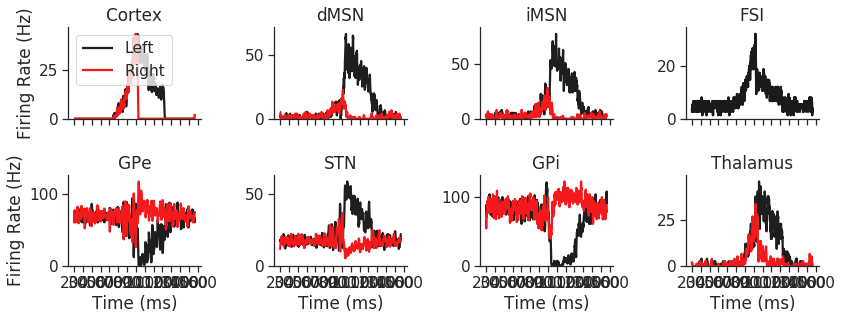

In [290]:
vis.plot_trial_rates(t=0)

In [291]:
results = ng.readAllTrialResults(8,0,sweepcount,['popfreqs','popweights','popQ1s','popQ2s','dopamine', 'popEs'])
decisions = []
for sn in range(sweepcount):
    decisions.append([])
    for result in results[sn]:
        decisions[sn].append(ng.findOutputs2(result)['decision made'])
#decisions

(0, 100)

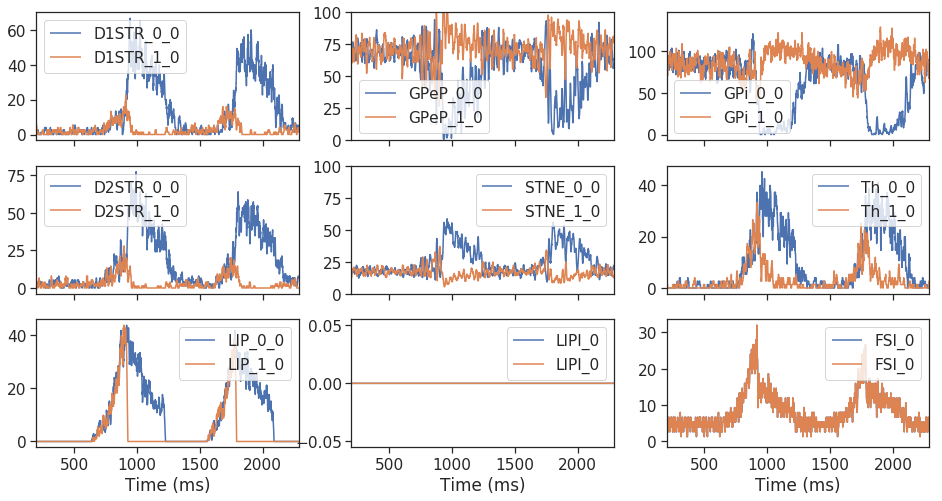

In [292]:
result = results[0][0]

f, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(16,8), sharex=True)
for i in range(0,result['dims']['choices']):
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax1[0])
    result['popfreqs'].plot(x='Time (ms)', y='GPeP_'+str(i)+'_0', ax=ax1[1])
    result['popfreqs'].plot(x='Time (ms)', y='GPi_'+str(i)+'_0', ax=ax1[2])
    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2[0])
    result['popfreqs'].plot(x='Time (ms)', y='STNE_'+str(i)+'_0', ax=ax2[1])
    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax2[2])
    result['popfreqs'].plot(x='Time (ms)', y='LIP_'+str(i)+'_0', ax=ax3[0])
    result['popfreqs'].plot(x='Time (ms)', y='LIPI_0', ax=ax3[1])
    result['popfreqs'].plot(x='Time (ms)', y='FSI'+'_0', ax=ax3[2])

for ax, axx, axxx in zip(ax1, ax2, ax3):
    ax.set_xlim(200, ax.get_xlim()[-1])#(750,900)#
    axx.set_xlim(200, axx.get_xlim()[-1])#(750,900)#
    axxx.set_xlim(200, axxx.get_xlim()[-1])#(750,900)#

ax2[1].set_ylim(0,100)
ax1[1].set_ylim(0,100)

#plt.savefig('FR_ramping.png', dpi=400)

accuracy overall: 0.8333333333333334
first 15: 0.8333333333333334
everything else: nan


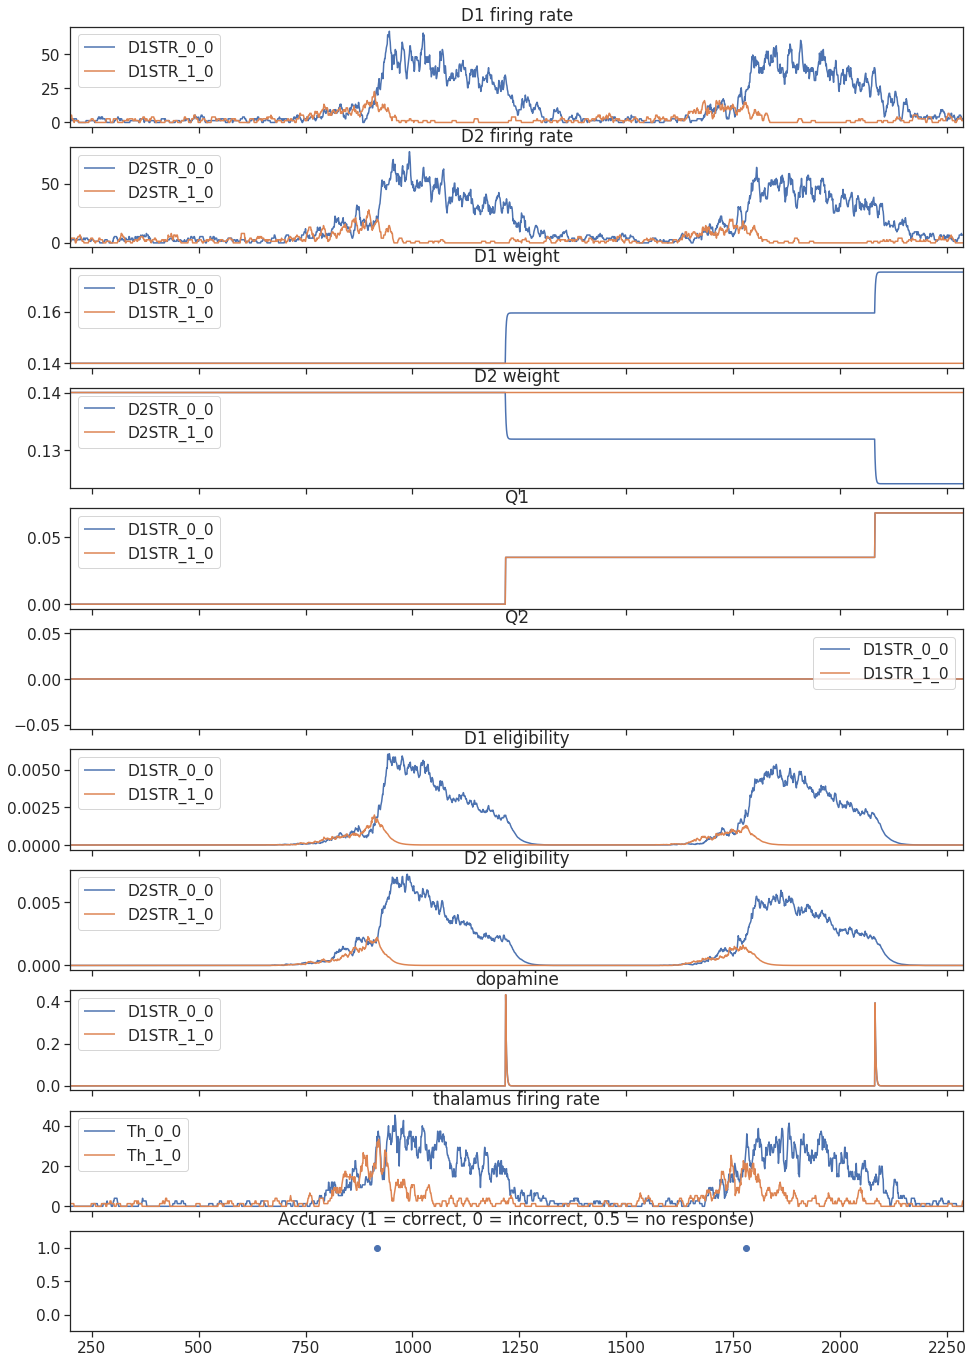

In [293]:
simnum = 0

result = results[0][simnum]

stagecount = len(decisions[0][0])
reacttimes = []
reactions = []
allreactions = []
for i in range(0, stagecount):
    if decisions[0][simnum][i]['pathvals'] != None and len(decisions[0][simnum][i]['pathvals']) > 0:
        reactions.append(1-decisions[0][simnum][i]['pathvals'][0])
    else:
        reactions.append(0.5)
    reacttimes.append(decisions[0][simnum][i]['time'])
#print(reactions)
#print('accuracy overal: ' + str(np.mean(reactions)))

f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = plt.subplots(11, 1, figsize=(16,24), sharex=True)
for i in range(0,result['dims']['choices']):
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax1, title='D1 firing rate')
    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2, title='D2 firing rate')
    result['popweights'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax3, title='D1 weight')
    result['popweights'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax4, title='D2 weight')
    result['popQ1s'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax5, title='Q1')
    result['popQ2s'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax6, title='Q2')
    result['popEs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax7, title='D1 eligibility')
    result['popEs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax8, title='D2 eligibility')
    result['dopamine'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax9, title='dopamine')
    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax10, title='thalamus firing rate')
    

ax1.set_xlim(200, ax.get_xlim()[-1])#(250,750)#(2500,2750)#(750,1200)#(750,1000)#(200, ax.get_xlim()[-1])#
ax2.set_xlim(200, ax.get_xlim()[-1])#(250,750)#(2500,2750)#(750,1200)#(750,1000)#(200, ax.get_xlim()[-1])#
#ax1.set_xlim(0, 1000)#(250,750)#
#ax2.set_xlim(0, 1000)#(250,750)#



ax11.plot(reacttimes,reactions, marker='o', linestyle='None')
ax11.set_title('Accuracy (1 = correct, 0 = incorrect, 0.5 = no response)')
ax11.set_ylim(-0.25,1.25)

#ax3.set_ylim(.995,1.0025)

print('accuracy overall: ' + str(np.mean(reactions)))
print('first 15: ' + str(np.mean(reactions[:15])))
print('everything else: ' + str(np.mean(reactions[15:])))

#plt.savefig('/home/mclapp/Desktop/90_10_prob_feeback.png', dpi=400)
#plt.savefig('test.png', dpi=400)

# Sample stimulus intensity across trials

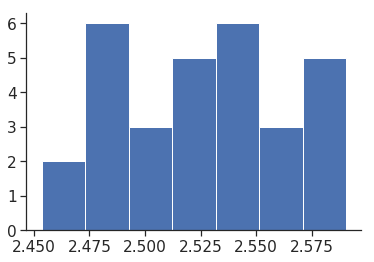

In [168]:
ntrials = 30
stimArray = vis.plot_stim_dist(mu=2.5, sd=.075, clip=(2.45, 2.6), ntrials=ntrials, bins=7) 

# Simulate full dataset
* 5 sampled CBGT networks
* 3 conditions (Low, Medium, and High reward)
* 20 trials / condition (see cell above)

In [16]:
bdf_list, rdf_list, ardf_list  = [], [], []
msn_idx_list, msn_cond_list = [], []
msn_pops = ['dMSN0', 'dMSN1', 'iMSN0', 'iMSN1']

for cond_ix, cond in enumerate(conds):
    
    bdf_list_c, rdf_list_c, ardf_list_c = [], [], []
    preset_c = presets[cond_ix]
    
    savedir_c = savedirs[cond_ix]
    if not os.path.isdir(savedir_c):
        os.mkdir(savedir_c)
    
    for i, subject_eff in enumerate(subj_eff_dicts):
        
        savedir_ci = os.path.join(savedir_c, str(i)) 
        if not os.path.isdir(savedir_ci):
            os.mkdir(savedir_ci)
            
        res_ci = sim.run_cbgt_sweeps(stimArray, preset=preset_c, 
                                    rampingCTX=True, savedir=savedir_ci, 
                                    cond=cond, ntrials=ntrials, Start=Start, 
                                    popscale=popscale, BaseStim=BaseStim, 
                                    Dynamic=Dynamic, Choices=Choices, 
                                    conEff=subject_eff, conProb=conProb)

        bdf_ci = afx.analyze_network_behavior(res_ci, preset_c, 
                                              stimArray, cond, 
                                              savedir_ci, idx=i,
                                              conEff=subject_eff)

        ratedf_ci, avg_ratedf_ci = vis.save_and_plot(res_ci, bdf_ci, 
                                                    cond=cond, idx=i, 
                                                    savedir=savedir_ci, 
                                                    window=None, Start=Start, 
                                                    trials=[1], getdfs=True)
        
        vis.plot_cond_rtdist(bdf_ci, bins=8, 
                             cond=cond, outdir=savedir_ci, 
                             norm_hist=False)
        vis.plot_cor_err_rts(bdf_ci, bins=8, 
                             outdir=savedir_ci, 
                             norm_hist=False)
        plt.close('all')
        
        msnDF = ratedf_ci[ratedf_ci.population.isin(msn_pops)].reset_index(drop=True)
        msnDF_fname = 'msnRates_allTrials_{}_idx{}.csv'.format(cond, i)
        msnDF.to_csv(os.path.join(savedir_ci, msnDF_fname), index=False)

        bdf_list_c.append(bdf_ci)
        rdf_list_c.append(ratedf_ci)
        ardf_list_c.append(avg_ratedf_ci)
        msn_idx_list.append(msnDF)
        
    bdf_list.append(pd.concat(bdf_list_c).reset_index(drop=True))
    rdf_list.append(pd.concat(rdf_list_c).reset_index(drop=True))
    ardf_list.append(pd.concat(ardf_list_c).reset_index(drop=True))
    msn_cond_list.append(pd.concat(msn_idx_list).reset_index(drop=True))

msnAll = pd.concat(msn_cond_list).reset_index(drop=True)
bdf = pd.concat(bdf_list).reset_index(drop=True)
ratedf = pd.concat(rdf_list).reset_index(drop=True)
ardf = pd.concat(ardf_list).reset_index(drop=True)

Cond: LOW
	Mean CorRT:	394.01 (28.78)
	Med CorRT:	371.00
	Avg ErrRT:	394.38 (31.60)
	P(Left):	0.6522
Cond: LOW
	Mean CorRT:	470.46 (31.01)
	Med CorRT:	453.01
	Avg ErrRT:	483.01 (194.32)
	P(Left):	0.8696
Cond: LOW
	Mean CorRT:	407.24 (24.69)
	Med CorRT:	396.01
	Avg ErrRT:	417.01 (34.86)
	P(Left):	0.7391
Cond: HIGH
	Mean CorRT:	388.96 (21.92)
	Med CorRT:	371.00
	Avg ErrRT:	400.51 (79.00)
	P(Left):	0.9130
Cond: HIGH
	Mean CorRT:	449.55 (25.58)
	Med CorRT:	421.01
	Avg ErrRT:	999.99 (0.00)
	P(Left):	1.0000
Cond: HIGH
	Mean CorRT:	408.37 (22.47)
	Med CorRT:	394.01
	Avg ErrRT:	410.01 (74.00)
	P(Left):	0.9167


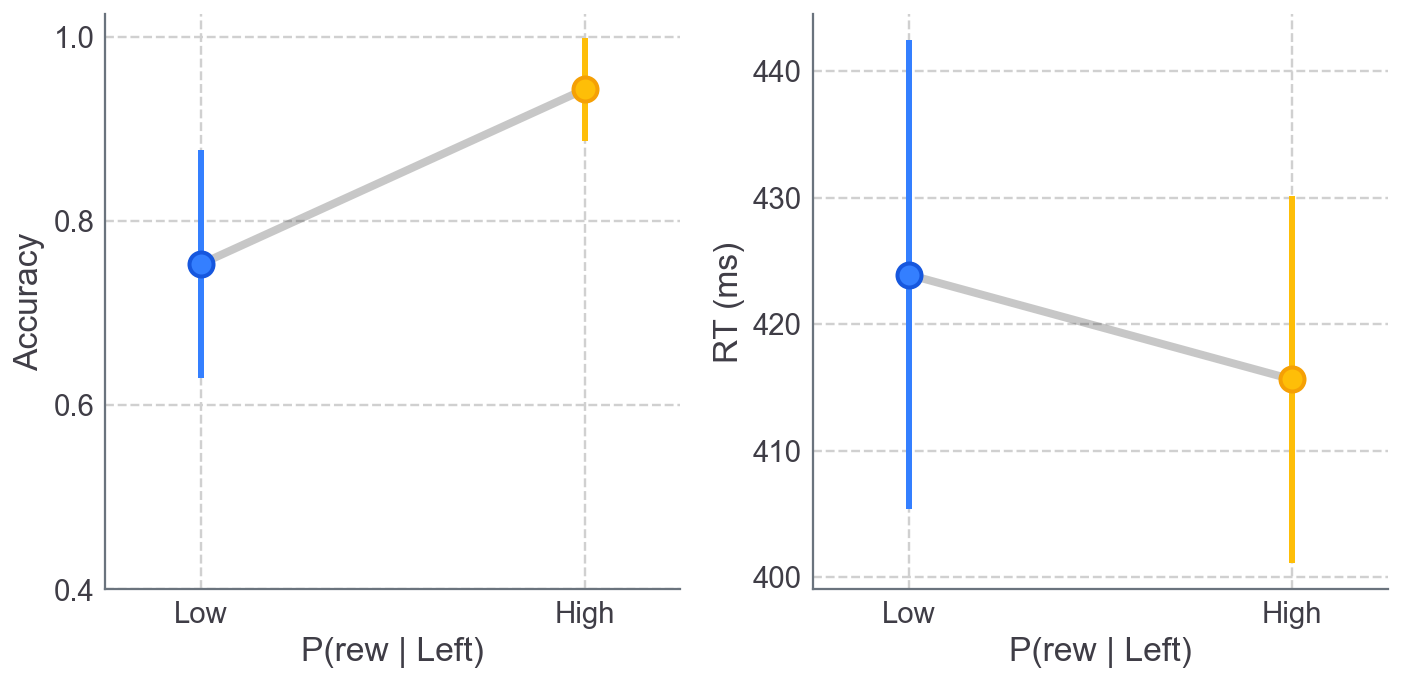

In [28]:
vis.plot_mean_acc_rt(bdf, conds=conds, subject_mean=True, clrs=clrs, eclrs=eclrs)

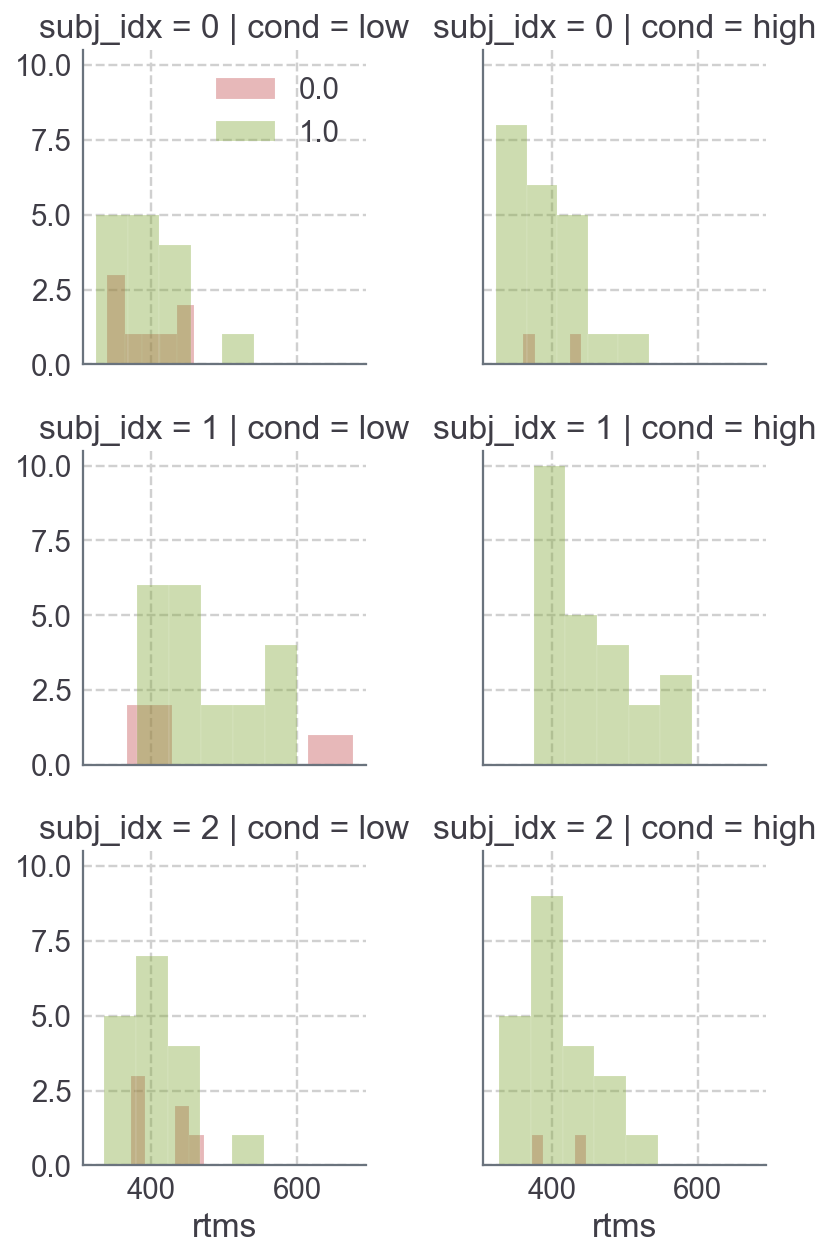

In [29]:
bdfx = bdf[bdf.acc.isin([0,1])]
gf=sns.FacetGrid(bdfx, hue='acc', row='subj_idx', col='cond', palette={0:'r', 1:'g'}, legend_out=False)
gf.map(sns.distplot, 'rtms', bins=5, kde=False, hist=True, kde_kws=dict(bw=1, shade=True))
gf.axes[0,0].legend()
plt.tight_layout()

In [30]:
bdf = afx.get_cbgt_covariates(bdf, msnAll, conds=conds)
bdf = afx.norm_covariates(bdf.dropna())

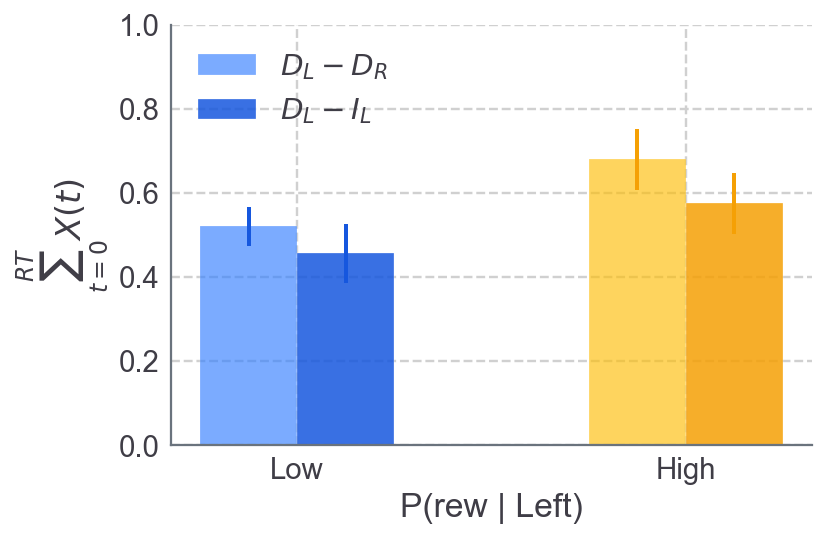

In [31]:
vis.plot_striatal_regressors(bdf, msn_type='d', subject_mean=True, conds=conds, clrs=clrs, eclrs=eclrs)

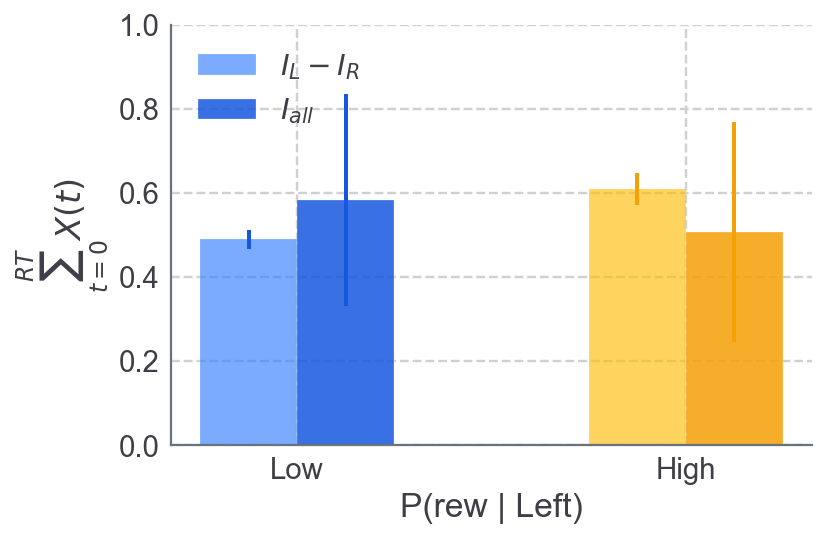

In [32]:
vis.plot_striatal_regressors(bdf, msn_type='i', subject_mean=True, conds=conds, clrs=clrs, eclrs=eclrs)

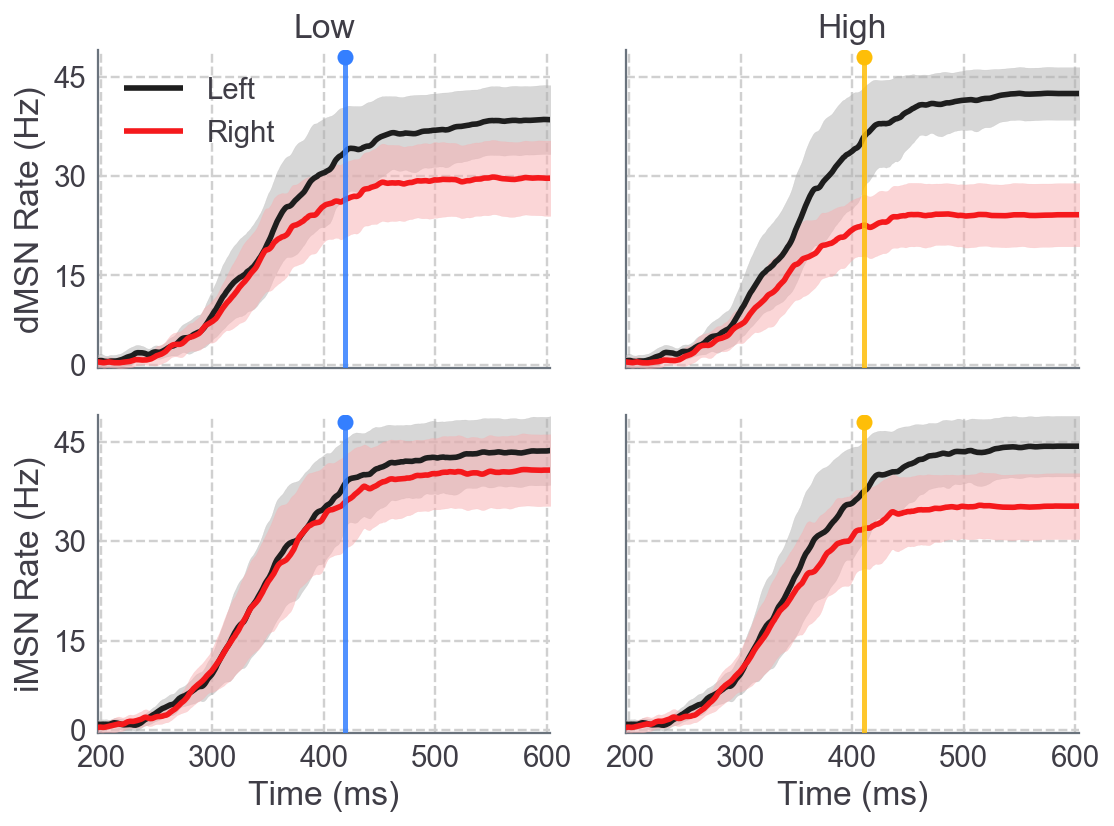

In [33]:
msnPad = msnAll.fillna(method='pad', axis=1).convert_objects(convert_numeric=True)
msnDFs = [msnPad[msnPad.population==pop].reset_index(drop=True) for pop in msn_pops]
ys, ysErr = afx.get_avgMSN_traces(msnDFs, window=5)
vis.plot_average_msn_rates(ys, ysErr, bdf, ntime=600, ymax=48, lw=2.8, plotRT=True, conds=conds, clrs=clrs, eclrs=eclrs)

In [5]:
def save_hddm_params(m, hddm_savedir, mname='va'):

    mname = '{}_stats'.format(mname)
    
    if not os.path.exists(hddm_savedir):
        os.mkdir(hddm_savedir)
    
    m.print_stats(os.path.join(hddm_savedir, '{}.txt'.format(mname)))
    statdf = m.gen_stats()
    statdf = statdf.reset_index()
    statdf = statdf.rename(columns={'index': 'param'})
    statdf.to_csv(os.path.join(hddm_savedir, '{}_df.csv'.format(mname)))

In [4]:
import hddm
hddm_savedir = os.path.join(os.path.expanduser('~'), 'hddm_fits')

data = bdf.reset_index(drop=True)
bias = True
inform = True
incl = ['z']
dependsCol = 'level'
nsamples = 2500
nburn = 1000

nullm = hddm.HDDM(data, bias=bias, include=incl, informative=inform)

freep = ['a', 't', 'v', 'z', 'va', 'vt', 'vz']
models = {}
for p in freep:
    plist = list(p)
    nfree = len(plist)
    depends = dict(zip(plist, [dependsCol]*nfree))
    m = hddm.HDDM(data, depends_on=depends, bias=bias, 
                  include=incl, informative=inform)
    models[p] = m

In [6]:
nullm.sample(nsamples, burn=nburn)
save_hddm_params(nullm, hddm_savedir, 'null')
nullm.dic_info

 [-----------------100%-----------------] 500 of 500 complete in 8.0 sec

{'DIC': -300.33993876360842,
 'deviance': -308.8700764342064,
 'pD': 8.5301376705979806}

In [11]:
dics = []
for mname in freep:
    m = models[mname]
    m.sample(nsamples, burn=nburn)
    save_hddm_params(m, hddm_savedir, mname)
    dics.append(m.dic)

 [-----------------100%-----------------] 2500 of 2500 complete in 69.0 sec

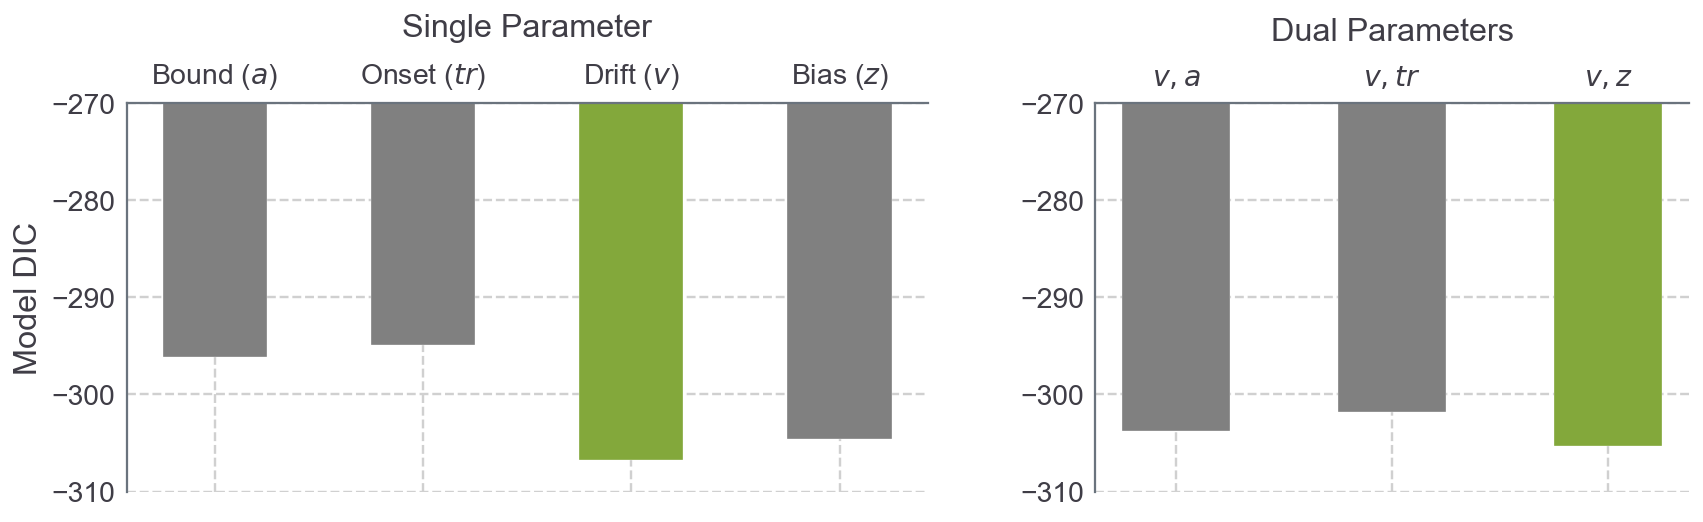

In [28]:
splot.style(figsize=(14,5))
freep = ['a', 't', 'v', 'z', 'va', 'vt', 'vz']
singles = [models[mname] for mname in freep[:4]]
duals = [models[mname] for mname in freep[4:]]
dics1 = dics[:4]
dics2 = dics[4:]
bestSingle = np.argmin(dics1)
bestDual = np.argmin(dics2)

# uncomment for delta DIC
# dics1 = [mm.dic - nullm.dic for mm in singles]
# dics2 = [mm.dic - nullm.dic for mm in duals]

lbls1 = ['Bound ($a$)','Onset ($tr$)','Drift ($v$)','Bias ($z$)']
lbls2 = ['$v,a$', '$v,tr$', '$v,z$']
clrs1 = ['Gray']*4
clrs2 = ['Gray']*3
clrs1[bestSingle] = 'g'
clrs2[bestDual] = 'g'

import matplotlib.gridspec as gridspec
f = plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.35,1], wspace=.24, top=.8)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

_ = ax1.bar(np.arange(4), dics1, color=clrs1, width=.5)
_ = ax2.bar(np.arange(3), dics2, color=clrs2, width=.5)
ax1.set_xticks(np.arange(4))
ax2.set_xticks(np.arange(3))
ax1.set_xticklabels(lbls1)
ax2.set_xticklabels(lbls2)

ymax = np.round(np.max(dics)*.0001, 2)*10000 + 30
ymin = np.round(np.min(dics)*.0001, 2)*10000 - 10
for ax in [ax1,ax2]:
    ax.set_ylim(ymax, ymin)
    ax.invert_yaxis()
    ax.xaxis.set_label_position("top")
    sns.despine(top=False,bottom=True,ax=ax)

ax1.set_ylabel('Model DIC')
# ax1.set_ylabel('$\Delta$ DIC')
ax1.set_xlabel('Single Parameter', labelpad=12)
ax2.set_xlabel('Dual Parameters', labelpad=12)
plt.tight_layout()
# fname = os.path.join(savedir, 'hddm/modelDICs.png')
# plt.savefig(fname, dpi=600)

In [7]:
import itertools
Xs = ['nD_lrdiff_sum', 'nDI_ldiff_sum', 'nI_LR_mean']
combos = [list(s) for s in list(itertools.combinations(Xs, 2))]
formulas = [["v ~ {}:C(level)".format(X1), 'a ~ {}:C(level)'.format(X2)] for (X1, X2) in combos]

In [ ]:
data = bdf.reset_index(drop=True)
interact = True
group_reg = True
bias = False

incl=['z']
bias=True
    
model_ids = np.arange(N)
models = {}
for mID in model_ids:
    reg_formula = formulas[mID]
    models[mID] = hddm.HDDMRegressor(data, reg_formula, bias=bias, include=incl, 
                                     keep_regressor_trace=True, 
                                     group_only_regressors=group_reg)

In [ ]:
for mID in model_ids:

    print('\nModel ID: {}\n'.format(mID))
    
    m = models[mID]
    m.sample(2000, burn=1200)

    statdf = m.gen_stats()
    statdf['modelID'] = mID
    statdf['DIC'] = m.dic_info['DIC']
    statdf['deviance'] = m.dic_info['deviance']
    statdf['pD'] = m.dic_info['pD']
    statdf = statdf.reset_index()
    statdf = statdf.rename(columns={'index':'param'})
    #statdf = split_param_col(statdf, param_reg)
    
    print('\nM{} DIC: {}'.format(mID, int(m.dic_info['DIC'])))